# Experiment on Behavioral cloning Project

In [1]:
import os
import csv
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Read in data

In [2]:
# data samples directories
data_dir = 'data/'
samples = []
with open(os.path.join(data_dir,'driving_log.csv')) as f:
    reader = csv.reader(f)
    for line in reader:
        samples.append(line)

# pop out first descriptive line
samples.pop(0)

['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

### i. Load in steer angle and image directories

In [3]:
# steer angles
steer_angle = []

# images
c_images_dir = []
l_images_dir = []
r_images_dir = []
for line in samples:
#     print(type(line[0]))
#     image = cv2.imread()
    c_images_dir.append(os.path.join(data_dir,line[0].strip())) # convert read in bgr image to rgb image
    
#     image1 = cv2.imread()
    l_images_dir.append(os.path.join(data_dir,line[1].strip())) # convert read in bgr image to rgb image
    
#     image = cv2.imread()
    r_images_dir.append(os.path.join(data_dir,line[2].strip())) # convert read in bgr image to rgb image
    steer_angle.append(float(line[3]))

### ii. Using left-view and right-view images with steer angle adjustment 

In [4]:
# steer angle for left-view images and right-view images
steer_angle = np.array(steer_angle)
l_steer_angle, r_steer_angle = steer_angle+0.25 , steer_angle-0.25
y_train = np.concatenate((steer_angle,l_steer_angle,r_steer_angle))
# image directories for all images
X_train_dir = np.concatenate((c_images_dir,l_images_dir,r_images_dir))

In [5]:
print('Total steer angle size is    : {}'.format(y_train.shape))
print('Total training images size is :{}'.format(X_train_dir.shape))
print(y_train[100])

Total steer angle size is    : (24108,)
Total training images size is :(24108,)
-0.05975719


## 2. Visualize data

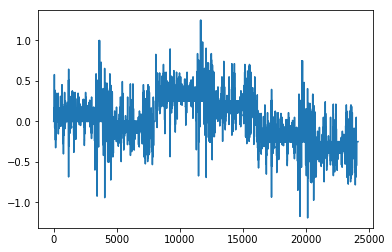

In [6]:
# print(len(steer_angle))
plt.plot(y_train)

In [7]:
# plt.hist(steer_angle,rwidth=0.5)
# sns.distplot(steer_angle, kde=False, rug=True)
# sns.kdeplot(y_train, shade=True, cut=0)
# sns.rugplot(y_train)

## 3 Image augmentation

### i. Image translation

In [8]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

In [28]:
rows,cols = 160,320
# randomly translate images with steer angle adjustment
def trans_image(image,steer,trans_range):
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 40*np.random.uniform()-40/2
    #tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang

In [10]:
def add_random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image

In [27]:
# import math
# new_size_col,new_size_row = 64, 64
# def preprocessImage(image):
#     shape = image.shape
#     # note: numpy arrays are (row, col)!
#     image = image[math.floor(shape[0]/5):shape[0]-25, 0:shape[1]]
#     image = cv2.resize(image,(new_size_col,new_size_row), interpolation=cv2.INTER_AREA)    
#     return image

nb_samples = len(y_train)

def preprocess_image_file_train(input_x, input_y):
    rand_index = np.random.randint(len(input_x))
    y_steer = input_y[rand_index]
    i_path = input_x[rand_index]
    image = cv2.imread(i_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image,y_steer = trans_image(image,y_steer,100)
    image = augment_brightness_camera_images(image)
#     image = preprocessImage(image)
    image = np.array(image)
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image = cv2.flip(image,1)
        y_steer = -y_steer
    
    return image,y_steer

## 4 CNN model

In [12]:
from keras.layers import Dense,Dropout,Conv2D,Lambda,Cropping2D,Reshape,Flatten
from keras.models import Sequential,save_model
from keras.backend import tf as ktf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


### i. Architecure

In [13]:
model = Sequential()

# preprocess layers
model.add(Lambda(lambda x: x/255.0-0.5,input_shape = (160,320,3),name ='lambda_normalize_layer'))
model.add(Cropping2D(cropping=((70, 25), (0, 0))))
# model.add(Reshape((64,64,3)))

model.add(Lambda(lambda image: ktf.image.resize_images(image, (64,64))))
# color space self-adaptation layer
model.add(Conv2D(3,1,1,activation='elu',name='cv_1_3x1x1')) 

# basic feature learning layers
# input shape: 64x64x3, output shape: 32x32x24
model.add(Conv2D(24,5,5,border_mode='same',subsample=(2,2),activation='elu',name='cv_2_24x5x5'))
# input shape: 32x32x24, output shape: 16x16x36
model.add(Conv2D(36,3,3,border_mode='same',subsample=(2,2),activation='elu',name='cv_3_36x3x3'))
# input shape: 16x16x36, output shape: 8x8x48
model.add(Conv2D(48,3,3,border_mode='same',subsample=(2,2),activation='elu',name='cv_4_48x3x3'))
model.add(Dropout(0.5))

# complicated feature learning layers
# input shape: 8x8x48, output shape: 6x6x64
model.add(Conv2D(64,3,3,activation='elu',name='cv_5_64x3x3'))
# input shape: 6x6x64, output shape: 4x4x64
model.add(Conv2D(64,3,3,activation='elu',name='cv_6_64x3x3'))
model.add(Dropout(0.5))

# flatten layer
# input shape: 4x4x64, output shape: 1024
model.add(Flatten())

# Fully-connected layers
# input shape: 1024 output shape: 100
model.add(Dense(100,name='fc_1_100'))
# input shape: 100 output shape: 50
model.add(Dense(50,name='fc_2_50'))
# input shape: 50 output shape: 10
model.add(Dense(10,name='fc_3_10'))
model.add(Dropout(0.5))

# regression output layer
model.add(Dense(1))

### ii. data generator

In [29]:
def generate_train_from_PD_batch(input_x,input_y,batch_size = 32):
    
    batch_images = []
    batch_steering =[]
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(input_x))
            
            keep_pr = 0
            #x,y = preprocess_image_file_train(line_data)
            while keep_pr == 0:
                x,y = preprocess_image_file_train(input_x,input_y)
                if abs(y)<.01:
                    keep_pr = 0
                else:
                    keep_pr = 1
            
            #x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            #y = np.array([[y]])
            batch_images.append(x)
            batch_steering.append(y)
        yield batch_images, batch_steering

In [15]:
# data shuffle and split

# X_train_dir,y_train = shuffle(X_train_dir,y_train)

X_train,X_test_dir,Y_train,Y_test = train_test_split( X_train_dir,y_train,test_size=0.2)

In [24]:
# X_test =[]
# def test_r_generator(input_x,input_y,batch_size):
#     batch_images = np.zeros((batch_size, new_size_row, new_size_col, 3))
#     batch_steering = np.zeros(batch_size)
#     while 1:        
#         for i in range(batch_size):
#             i_line = np.random.randint(len(input_x))
#             i_path = input_x[i_line]
#             image = cv2.imread(i_path)
#             image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#             image = cv2.resize(image,(new_size_col,new_size_row), interpolation=cv2.INTER_AREA)
#             X_test.append(image)
            
def generator(input_x,input_y, batch_size=32):
    num_samples = len(input_y)
    while 1: # Loop forever so the generator never terminates
        shuffle(input_x,input_y)
        for offset in range(0, num_samples, batch_size):
            batch_samples = input_x[offset:offset+batch_size],input_y[offset:offset+batch_size]

            output_x = []
            output_y = []
            for batch_sample in batch_samples:
                name = batch_samples[0]
                print(name)
                center_image = cv2.imread(name)
                center_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                center_image = cv2.resize(image,(new_size_col,new_size_row), interpolation=cv2.INTER_AREA)
                center_angle = float(batch_sample[1])
                output_x.append(center_image)
                output_y.append(center_angle)

            # trim image to only see section with road
            output_x = np.array(output_x)
            output_y = np.array(output_y)
            yield output_x, output_y

In [30]:
from keras.models import load_model

epoch = 2
val_size = 1
pre_threshold = 1
batch_size = 64

train_r_generator = generate_train_from_PD_batch(X_train,Y_train,batch_size)
test_r_generator = generator(X_train,Y_train,batch_size)
print

model.compile(optimizer='rmsprop',
          loss='mse')

model.fit_generator(generator=train_r_generator,
                    samples_per_epoch=20000, 
#                     validation_data=test_r_generator, 
#                     nb_val_samples=len(Y_test),
                    nb_epoch=epoch,
                    verbose=1)

model.save('model.h5') 

Epoch 1/2


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 arrays but instead got the following list of 64 arrays: [array([[[ 51,  68,  95],
        [ 66,  83, 110],
        [ 76,  94, 121],
        ..., 
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 76,  93, 120],
        ...